#Install

In [ ]:
!pip install PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 17.1 MB/s eta 0:00:00


#Import

In [ ]:
# NLP Tools

import PyPDF2
import json
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
# For ABSA
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Progress bar
from tqdm import tqdm

# Display
import matplotlib.pyplot as plt
import pandas as pd

# Connect to drive


In [ ]:
# connect to google
from google.colab import drive
drive.mount('/content/drive')

# Change path accordingly
path = "/content/drive/MyDrive/Colab Notebooks/EP/t_processed/"

Mounted at /content/drive


# Proper data process

In [ ]:
def load_json(path_in):
  with open(path_in, 'r') as file:
    data = json.load(file)
  return data

def make_list(cont_str): # Sentence Tokenize and clen text
  sentences = sent_tokenize(cont_str)
  clean_sentences = [sent.replace("\n","") for sent in sentences]

  return clean_sentences

def make_continuous(data): # Extract all the relevant data format it for ABSA

  # In details
  continuous_string = data['Details'][0]['Presentation']

  # In qa
  # for every qa pair, add the entries q, a1, ..., an for n answers
  qna_ext_details = ['question', 'answer1', 'answer2', 'answer3', 'answer4', 'answer5', 'answer6', 'answer7', 'answer8']

  for qa_pair in data['qa']: # init questions loop


    to_extract = [] # Reset extraction keychain
    ######
    for key in qa_pair.keys(): # iterate through keys
      if key in qna_ext_details: # check key relativity
        to_extract.append(key) # add relevant key to extraction keychain

    for key in to_extract: # Modify continuous string
      # print(key)
      continuous_string += " \n"
      continuous_string += qa_pair[key]
    ######

  return make_list(continuous_string)

# Opinion mining / Aspect Based Sentiment Analysis / Target SA

In [ ]:
# TRANSCRIPTS PER BANK

# UBS
UBS_transcripts = [
    "UBS/2023_Q1.json", "UBS/2023_Q2.json", "UBS/2023_Q3.json", "UBS/2023_Q4.json",
    "UBS/2024_Q1.json", "UBS/2024_Q2.json", "UBS/2024_Q3.json", "UBS/2024_Q4.json",
    "UBS/2025_Q1.json",
    ]

# JPMorgan
JPM_transcripts = [
    "JPMorgan/2023_Q1.json", "JPMorgan/2023_Q2.json", "JPMorgan/2023_Q3.json", "JPMorgan/2023_Q4.json",
    "JPMorgan/2024_Q1.json", "JPMorgan/2024_Q2.json", "JPMorgan/2024_Q3.json", "JPMorgan/2024_Q4.json",
    "JPMorgan/2025_Q1.json",
    ]

# Citi
Citi_transcripts = [
    "Citi/2023_Q1.json", "Citi/2023_Q2.json", "Citi/2023_Q3.json", "Citi/2023_Q4.json",
    "Citi/2024_Q1.json", "Citi/2024_Q2.json", "Citi/2024_Q4.json",
    "Citi/2025_Q1.json",
    ]

In [ ]:
# ASPECTS PER BANK
# These topics are manually extracted from the topic modelling results. They are grouped by bank

UBS_aspects = [
  # 1 Pressure on Net Interest Margin (NIM)
  'NIM',
  'net interest margin',
  ' interest ',
  # ' rate ',
  # ' interest rate',
  # 2 Concerns about IT Systems and Cyber Security
  ' IT ',
  # ' cyber',
  # ' cybersecurity',
  # 3 Exposure to the Commercial Real Estate (CRE) Sector
  ' real estate',
  # 4 Capital Adequacy and regulatory Changes
  ' regulation',
  ' regulatory',
  # ' capital adequacy',
  # 5 Strategic Exit/Exposure to Emerging Markets
  ' innovation',
  ' emerging markets'
]

JPM_aspects = [
    # 1 Loan book quality increase in defaults
    ' loan',
    ' default',
    # 2 IT Infrastructure and Cybersecurity
    # ' IT',
    ' cybersecurity',
    ' cyber',
    # 3 Market concerns about liquidity risk / Bank's liquidity position and reliance on wholesale funding
    ' wholesale',
    ' liquid',
    # ' liquidity risk',
    # 4 Increased exposure to emerging markets
    # ' emerging markets',
    ' emerg', # Emerging markets
    ' innovation',
    # Reputation and negative media coverage/ Concerns about the bank's culture and conduct
    # ' reputation',
    ' culture',
    # ' conduct',
    ' media',
    ' coverage',

]

Citi_aspects = [
    # 1 Digital Transformation Efforts
    ' digital',
    # ' transofrm',
    # 2 Cybersecurity Measures and Talent Retention
    ' cyber',
    # ' cybersecurity',
    ' talent',
    ' retain',
    # 3 Exposure to the Commercial Realestate market
    # ' real estate',
    # ' commercial real estate',
    # 4 Capital adequacy
    ' capital',
    # 5 Impact of low interest rate environment on NIM / Pressure on NIM
    ' interest',
    # ' rate ',
    ' interest rate',
    # 'NIM',
    ' net interest margin',
]

In [ ]:
# Check GPU availability

USE_CUDA = True

if USE_CUDA and torch.cuda.is_available():
  device = torch.device("cuda")
  print("cuda available")
else:
  device = torch.device("cpu")
  print("cuda not available")

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

cuda available
Using device: cuda


In [ ]:
# Load model and tokenizer

model_name = "yangheng/deberta-v3-base-absa-v1.1" # Chosen Classification model

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.to(device) # Apply to cuda if available

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

In [ ]:
# Format imput and predict sentiment for a specific aspect

def get_aspect_sentiment(sentence, aspect):

    # highlight asptect
    asp_formatted = sentence.replace(aspect, f"[ASP]{aspect}[ASP]")
    inputs = tokenizer(asp_formatted, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = model(**inputs).logits

    # Sentiment Analysis
    pred = torch.argmax(logits, dim=1).item()
    sentiment = ["negative", "neutral", "positive"][pred]

    return sentiment


In [ ]:
def run_ABSA(text_in, aspects_in, transcript_info):

  # Extract sentiments for given aspects
  results = [] # init return list

  for sent in text_in:
      for asp in aspects_in:
          if asp in sent:
              sentiment = get_aspect_sentiment(sent, asp) # Sentiment Analysis
              results.append((transcript_info[0], transcript_info[1], transcript_info[2], sent, asp, sentiment)) # Append to results

  # Format returned DataFrame
  df = pd.DataFrame(results, columns=["Bank", "Year", "Quarter", "Sentence", "Aspect", "Sentiment"])

  return df


In [ ]:

def ABSA_pipeline(bank, bank_transcripts, bank_aspects):

  # Define empty DataFrame
  df = pd.DataFrame(columns=['Bank', 'Year', 'Quarter', 'Sentence', 'Aspect', 'Sentiment'])

  # current_bank = None # Use this later to define which aspects are being analysed.

  for transcript in tqdm(bank_transcripts, desc=f"Analysing {bank} Transcripts"):
    # load transcript
    transcript = load_json(path + transcript)

    # Extract transcript info
    transcript_info = [bank, transcript['Details'][0]['Year'], transcript['Details'][0]['quarter']]
    # print(transcript_info)

    # Clean transcript
    input_transcript = make_continuous(transcript)
    # print(input_transcript)

    # Feed into machine
    result_ABSA = run_ABSA(input_transcript, bank_aspects, transcript_info)

    # update df
    df = pd.concat([df, result_ABSA], ignore_index=True)

  return df


In [ ]:
df_Citi = ABSA_pipeline("Citi", Citi_transcripts, Citi_aspects)
df_UBS = ABSA_pipeline("UBS", UBS_transcripts, UBS_aspects)
df_JPM = ABSA_pipeline("JPMorgan", JPM_transcripts, JPM_aspects)

Analysing JPMorgan Transcripts: 100%|██████████| 9/9 [00:05<00:00,  1.55it/s]


In [ ]:
# Concatenate all 3 DataFrames
df_all = pd.concat([df_UBS, df_JPM, df_Citi], ignore_index=True)

In [ ]:
df_all

,Bank,Year,Quarter,Sentence,Aspect,Sentiment
0,UBS,2023,Q1,"In EMEA, clients continue to be cautious overa...",interest,positive
1,UBS,2023,Q1,"As we think about the future of this business,...",interest,neutral
2,UBS,2023,Q1,Activities outside of our strategic focus and ...,interest,neutral
3,UBS,2023,Q1,We have a lot of work ahead of us to bring our...,interest,neutral
4,UBS,2023,Q1,Slide 10 – Net interest income Moving to NII o...,interest,positive
...,...,...,...,...,...,...
797,Citi,2025,Q1,In terms of the curve and the NII guidance we ...,interest,neutral
798,Citi,2025,Q1,In terms of the curve and the NII guidance we ...,interest rate,neutral
799,Citi,2025,Q1,We like buying back and giving capital back to...,capital,neutral
800,Citi,2025,Q1,We've been talking about optimizing use of cap...,capital,neutral


# Results


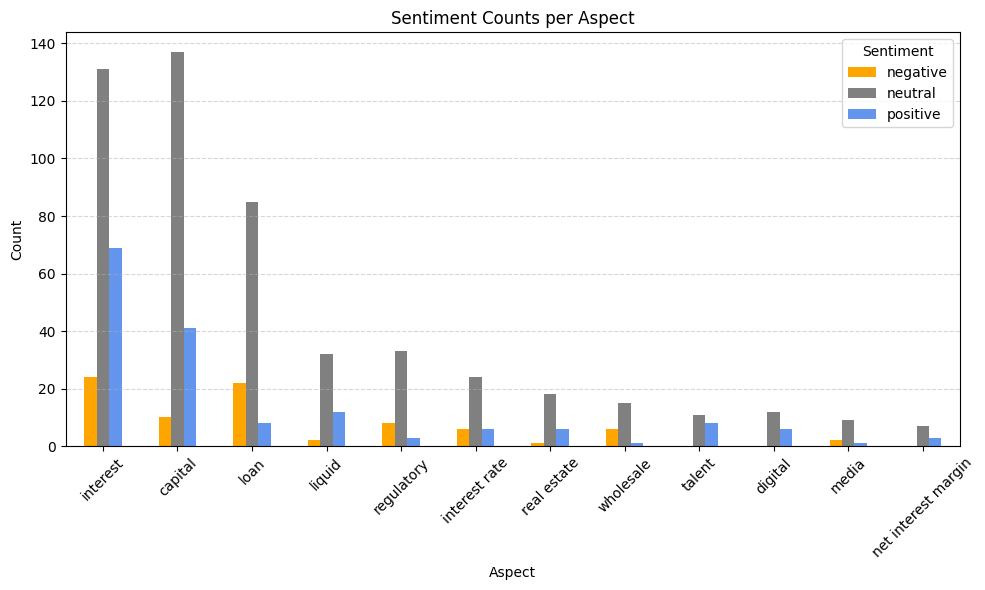

In [ ]:

for df in [df_UBS, df_JPM, df_Citi]:
    df['Aspect'] = df['Aspect'].str.strip()

# Strip the whitespace from the original aspect search
UBS_aspects   = [a.strip() for a in UBS_aspects]
JPM_aspects   = [a.strip() for a in JPM_aspects]
Citi_aspects  = [a.strip() for a in Citi_aspects]

# Create combined DataFrame
df_all = pd.concat([df_UBS, df_JPM, df_Citi], ignore_index=True)

# banks = ['UBS', 'JPMorgan', 'Citi', 'All']
banks = ['All']

for bank in banks:

    # Select DataFrame and aspect list
    if bank == "UBS":
        df_bank      = df_UBS
        select_aspects = UBS_aspects
        bank_label   = "UBS"
    elif bank == "JPMorgan":
        df_bank      = df_JPM
        select_aspects = JPM_aspects
        bank_label   = "JPMorgan"
    elif bank == "Citi":
        df_bank      = df_Citi
        select_aspects = Citi_aspects
        bank_label   = "Citibank"
    elif bank == "All":
        df_bank      = df_all
        select_aspects = UBS_aspects + JPM_aspects + Citi_aspects
        # deduplicste and preserving the order
        select_aspects = list(dict.fromkeys(select_aspects))
        bank_label   = "All"
    else:
        raise ValueError(f"Bank '{bank}' not recognised.")

    # Define color mapping
    sentiment_colors = {
        "negative": "orange",
        "neutral":  "grey",
        "positive": "cornflowerblue"
    }

    # Filter to only chosen aspects
    filtered_df = df_bank[df_bank['Aspect'].isin(select_aspects)]

    # Build the count table
    count_table = (
        filtered_df
        .groupby(['Aspect', 'Sentiment'])
        .size()
        .unstack(fill_value=0)
    )

    # Reindex to the desired aspect order
    count_table = count_table.reindex(select_aspects, fill_value=0)

    # Ensure sentiment columns in the right order
    count_table = count_table[["negative", "neutral", "positive"]]

    # Sort rows by total mentions
    count_table = count_table.loc[
        count_table.sum(axis=1).sort_values(ascending=False).index
    ]

    count_table = count_table.iloc[:12]

    # Plot
    ax = count_table.plot(
        kind='bar',
        figsize=(10, 6),
        color=[sentiment_colors[s] for s in count_table.columns]
    )

    # Formatting
    plt.title(f"Sentiment Counts per Aspect") # plt.title(f"Sentiment Counts per Aspect: {bank_label}")
    plt.xlabel("Aspect")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.legend(title="Sentiment")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

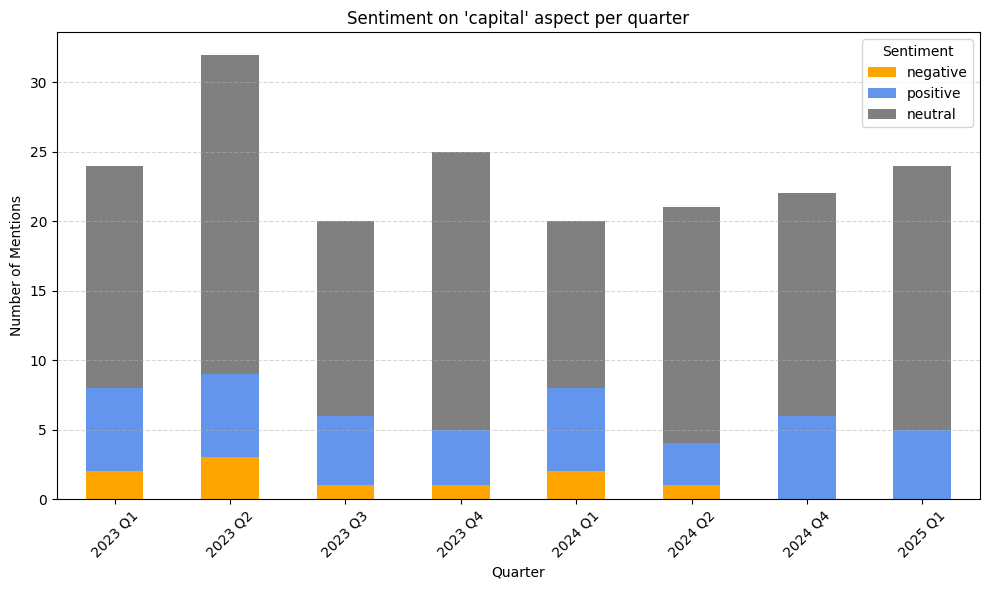

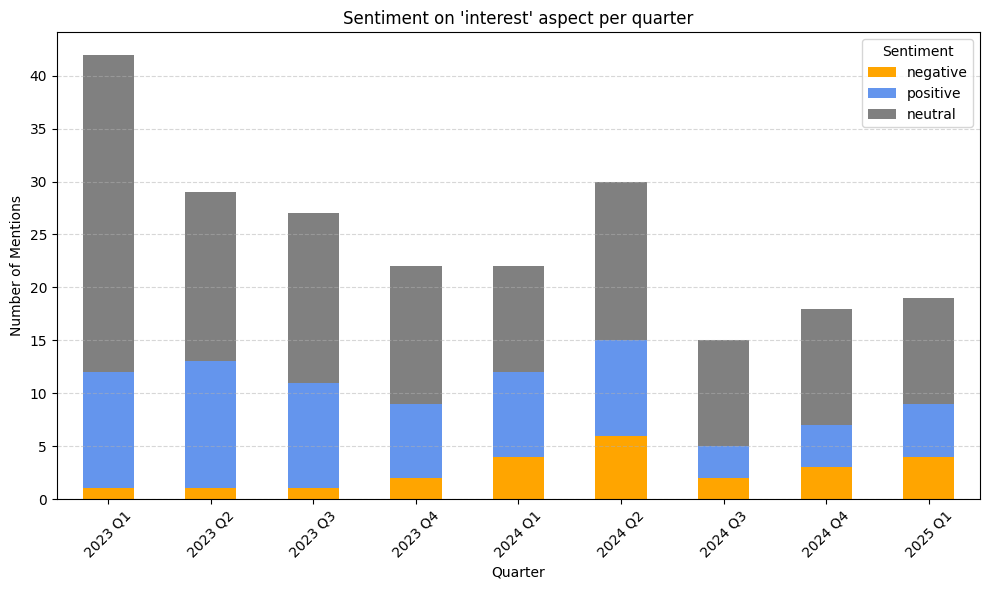

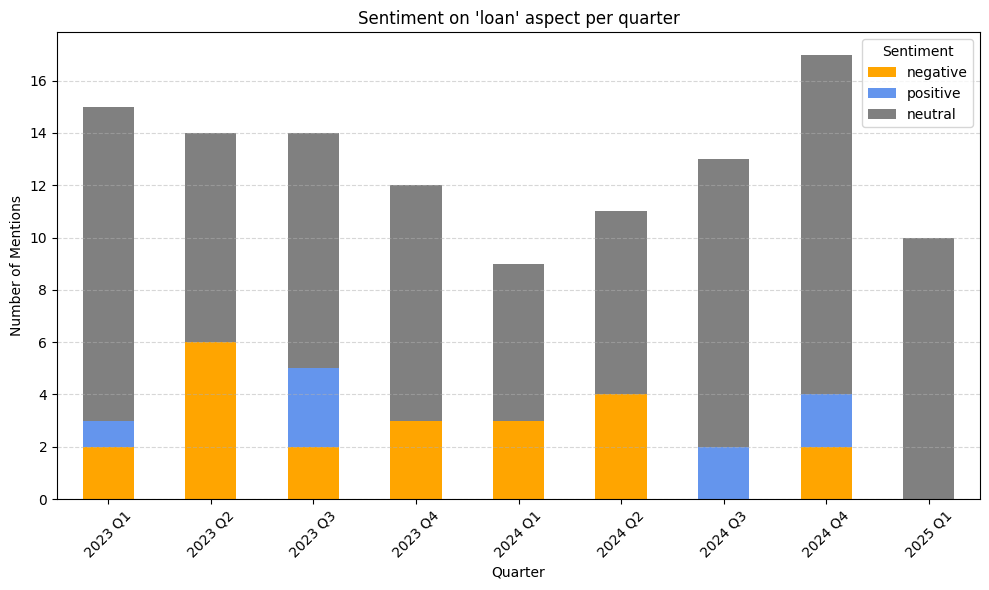

In [ ]:
# aspects = ["interest", 'rate', 'interest rate']
aspects = ['capital', 'interest', 'loan']

bank_df = df_all

for aspect in aspects:


  bank_df['Aspect'] = bank_df['Aspect'].str.strip()

  # Filter for the "interest" aspect
  df_interest = bank_df[bank_df['Aspect'] == aspect]

  # Group by Year, Quarter, and Sentiment
  grouped = df_interest.groupby(['Year', 'Quarter', 'Sentiment']).size().reset_index(name='Count')

  # Combine Year and Quarter into a single column
  grouped['Period'] = grouped['Year'].astype(str) + " " + grouped['Quarter']

  # Pivot the data to have sentiments as columns
  pivot = grouped.pivot(index='Period', columns='Sentiment', values='Count').fillna(0)

  # Ensure consistent column order (and fill missing sentiments if any)
  for sentiment in ['negative', 'positive', 'neutral']:
      if sentiment not in pivot.columns:
          pivot[sentiment] = 0

  pivot = pivot[['negative', 'positive', 'neutral']]  # Ensure column order

  # Define color mapping
  sentiment_colors = ["orange", "cornflowerblue", "grey"]

  # Plot

  pivot.plot(kind='bar', stacked=True, figsize=(10, 6), color=sentiment_colors)
  # pivot.plot(kind='line', marker='o', figsize=(10, 6), color=sentiment_colors)

  plt.title(f"Sentiment on '{aspect}' aspect per quarter")
  plt.xlabel("Quarter")
  plt.ylabel("Number of Mentions")
  plt.xticks(rotation=45)
  plt.legend(title="Sentiment")
  plt.tight_layout()
  plt.grid(axis='y', linestyle='--', alpha=0.5)
  plt.show()


In [ ]:
bank = 'All'

if bank == "UBS":
  df_bank = df_UBS
  bank_label = "UBS"
elif bank == "JPMorgan":
  df_bank = df_JPM
  bank_label = "JPMorgan"
elif bank == "Citi":
  df_bank = df_Citi
  bank_label = "Citibank"
elif bank == "All":
  df_bank = df_all
  bank_label = "All"
else:
  raise ValueError(f"Bank '{bank}' not recognised. Options: 'UBS', 'JPMorgan', 'Citi'.")

print((df_bank['Sentiment'].value_counts()['negative']/(df_bank['Sentiment'].value_counts()['negative'] + df_bank['Sentiment'].value_counts()['positive']))*100)

33.18385650224215


In [ ]:
print(path)

/content/drive/MyDrive/Colab Notebooks/EP/t_processed/


In [ ]:
# save df_all as a csv file
save_path = "/content/drive/MyDrive/Colab Notebooks/EP/"
df_all.to_csv(save_path + 'df_all.csv', index=False)